My Neural Network Class

In [1]:
import numpy as np
from  numpy import ndarray
from typing import List

In [2]:
def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
    assert array.shape == array_grad.shape, \
        '''
        Two ndarrays should have the same shape;
        instead, first ndarray's shape is {0}
        and second ndarray's shape is {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
    return None

Esta será la clase base para toda operación en la red neuronal, como puede ser un producto punto por ejemplo

- input gradient -> será la derivada parcial de cada elemento de la salida 

In [3]:
class Operation(object):
    """
    Clase base para toda operación interna en la red neuronal
    """
    
    
    def __init__(self):
        pass
    
    
    def forward(self, input_:ndarray):
        """
        Almacenamos la entrada y retornamos la salida global de la operación llamando a self.output_()
        """
        self.input_ = input_

        self.output = self._output()

        return self.output
    
    
    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Ejecuta la función self._input_grad(). Comprueba los tamaños de las matrices
        '''
        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad
 
    
    def _output(self) -> ndarray:
        '''
        El método _output es definido para cada subclase de Operation
        '''
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        El método _input_grad es definido para cada subclase de Operation
        '''
        raise NotImplementedError()
        

Para cada operación, necesitamos realizar un procedimiento específico dependiendo de los parámetros que reciba

In [4]:
class ParamOperation(Operation):
    '''
    Realiza una operación (heredando Operation) tomando unos parámetros de entrada
    '''

    def __init__(self, param: ndarray) -> ndarray:
        '''
        El método ParamOperation
        '''
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Ejecuta self._input_grad y self._param_grad.
        Comprueba el tamaño correcto de las matrices.
        '''

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Cada subclase de ParamOperation debe implementar un _param_grad específico.
        '''
        raise NotImplementedError()

Ahora ponemos en marcha operaciones específicas

In [5]:
class WeightMultiply(ParamOperation):
    '''
    Weight multiplication operation for a neural network.
    '''

    def __init__(self, W: ndarray):
        '''
        Inincializa la clase Operation con self.param = W.
        '''
        super().__init__(W)

    def _output(self) -> ndarray:
        '''
        Calcula la salida de la operación.
        '''
        return np.dot(self.input_, self.param)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Calcula el "gradiente de entrada", aplicando la regla de la cadena multiplicando el gradiente anterior por el de este
        '''
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad: ndarray)  -> ndarray:
        '''
        Calcula el gradiente de la operación (X*W), en términos de la entrada X
        '''        
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

In [6]:
class BiasAdd(ParamOperation):
    '''
    Calcula la suma del bias.
    '''

    def __init__(self,
                 B: ndarray):
        '''
        Inincializa el objeto Operation con self.param = B.
        Comprueba el tamaño del vector.
        '''
        assert B.shape[0] == 1
        
        super().__init__(B)

    def _output(self) -> ndarray:
        '''
        Calcula la operación (entrada + bias)
        '''
        return self.input_ + self.param

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Calcula el "gradiente de entrada", derivando la operación en términos del bias y multiplicando por el gradiente anterior
        '''
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Calcula el gradiente en términos del bias, sumando para cada fila
        '''
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [7]:
class Sigmoid(Operation):
    '''
    Función de activación Sigmoide
    '''

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> ndarray:
        '''
        Aplica la función no-lineal
        '''
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Calcula el gradiente, aplicando la regla de la cadena, multiplicando así dicho gradiente por el gradiente anterior
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        return input_grad

In [8]:
class Linear(Operation):
    '''
    "Identity" activation function
    '''

    def __init__(self) -> None:
        '''Pass'''        
        super().__init__()

    def _output(self) -> ndarray:
        '''Pass through'''
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''Pass through'''
        return output_grad

Implementando la clase Layer, que será la capa que realice las operaciones pertinentes

In [9]:
class Layer(object):
    '''
    Capa de nodos
    '''

    def __init__(self,
                 neurons: int):
        '''
        El número de nodos corresponde al "ancho" de la capa
        '''
        self.neurons = neurons
        self.first = True
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []

    def _setup_layer(self, num_in: int) -> None:
        '''
        La función _setup_layer debe ser implementada por cada instancia de capa
        '''
        raise NotImplementedError()

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Passes input forward through a series of operations
        ''' 
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Passes output_grad backward through a series of operations
        Checks appropriate shapes
        '''

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Extrae los _param_grads (gradientes) de las operaciones de la capa
        '''

        self.param_grads = [] #extraemos los gradientes de cada operación dentro de la capa
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Extrae los valores de los parámetros _params de las operaciones de la capa
        '''

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)

Dense heredará el objeto Layer (refiriéndose a la fully-connected-layer) donde serán especificados los parámetros de la capa actual, como son el nº de nodos y la función no-lineal de activación

In [10]:
class Dense(Layer):
    '''
    Una capa totalmente conectada heredada de "Layer"
    '''
    def __init__(self,
                 neurons: int,
                 activation: Operation = Sigmoid()):
        '''
        Requiere una función no-lineal de activación
        '''
        super().__init__(neurons)
        self.activation = activation

    def _setup_layer(self, input_: ndarray) -> None:
        '''
        Definimos las operaciones en la capa
        '''
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], self.neurons))

        # bias
        self.params.append(np.random.randn(1, self.neurons))

        self.operations = [WeightMultiply(self.params[0]), #básicamente, será la multiplicación de entrada por pesos, adicción de bias
                           BiasAdd(self.params[1]), 
                           self.activation] #y por último, aplicar la activación

        return None

La clase pérdida tomará los gradientes

In [11]:
class Loss(object):
    '''
    La "pérdida" de la NN
    '''

    def __init__(self):
        '''Pass'''
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
        Calcula el valor actual de la pérdida
        '''
        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output()

        return loss_value

    def backward(self) -> ndarray:
        '''
        Computes gradient of the loss value with respect to the input to the loss function
        '''
        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        '''
        Cada subclase de "Loss" debe implementar la función _output.
        '''
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        '''
        Cada subclase de "Loss" debe implementar la función _input_grad.
        '''
        raise NotImplementedError()

In [12]:
class MeanSquaredError(Loss):

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> float:
        '''
        Calcula la pérdida MSE de las predicciones
        '''
        loss = (
            np.sum(np.power(self.prediction - self.target, 2)) / 
            self.prediction.shape[0]
        )

        return loss

    def _input_grad(self) -> ndarray:
        '''
        Calcula el gradiente de la salida de la función de pérdidas MSE en términos de la predicción
        '''        

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

Finalmente, la clase de más alto nivel

In [13]:
class NeuralNetwork(object):
    '''
    La clase referente a la NN
    '''
    def __init__(self, 
                 layers: List[Layer],
                 loss: Loss,
                 seed: int = 1) -> None:
        '''
        La NN necesita una lista de las capas, y un objeto de la función de pérdidas.
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        

    def forward(self, x_batch: ndarray) -> ndarray:
        '''
        Pasa la entrada a través de la serie de capas
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)

        return x_out

    def backward(self, loss_grad: ndarray) -> None:
        '''
        Recoge los gradientes hacia atrás de las capas
        '''

        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return None

    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:
        '''
        - Pasa los datos hacia delante a través de las capas
        - Calcula el valor de pérdida
        - Pasa los gradientes hacia atrás para actualizar los pesos
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        '''
        Obtiene los parámetros de la red
        '''
        for layer in self.layers:
            yield from layer.params

    def param_grads(self):
        '''
        Obtiene el gradiente de la pérdida en términos de los parámetros de cada capa de la red
        '''
        for layer in self.layers:
            yield from layer.param_grads    

Optimizadores

In [14]:
class Optimizer(object):
    '''
    Base class for a neural network optimizer.
    '''
    def __init__(self,
                 lr: float = 0.01):
        '''
        Every optimizer must have an initial learning rate.
        '''
        self.lr = lr

    def step(self) -> None:
        '''
        Every optimizer must implement the "step" function.
        '''
        pass

In [15]:
class SGD(Optimizer):
    '''
    Stochasitc gradient descent optimizer.
    '''    
    def __init__(self,
                 lr: float = 0.01) -> None:
        '''Pass'''
        super().__init__(lr)

    def step(self):
        '''
        For each parameter, adjust in the appropriate direction, with the magnitude of the adjustment 
        based on the learning rate.
        '''
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):

            param -= self.lr * param_grad

# `Trainer`

In [163]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    '''
    Trains a neural network
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        '''
        Requires a neural network and an optimizer in order for training to occur. 
        Assign the neural network as an instance variable to the optimizer.
        '''
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        '''
        Generates batches for training 
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluated the neural network on the testing data.
        '''

        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        predictions_per_epoch = np.zeros((epochs, X_train.shape[0], X_train.shape[1]))

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)
            
            actual_preds = self.net.forward(X_train)
            predictions_per_epoch[e] = actual_preds

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)
                                
                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break
                    
        return predictions_per_epoch

#### Evaluation metrics

In [79]:
def mae(y_true: ndarray, y_pred: ndarray):
    '''
    Compute mean absolute error for a neural network.
    '''    
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
    '''
    Compute root mean squared error for a neural network.
    '''
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):
    '''
    Compute mae and rmse for a neural network.
    '''
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mae(preds, y_test)))
    print()
    print("Root mean squared error {:.2f}".format(rmse(preds, y_test)))

In [80]:
lr = NeuralNetwork(
    layers=[Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

nn = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

In [81]:
lr

### Read in the data, train-test split etc.

In [82]:
import pandas as pd

In [83]:
# from sklearn.datasets import load_boston
boston = pd.read_csv("boston.csv", index_col=[0])

data = boston.drop(columns="Price").values
target = boston.Price.values
features = boston.columns.values

In [84]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [85]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

### Train the three models

In [87]:
# helper function

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [88]:
trainer = Trainer(lr, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 100,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(lr, X_test, y_test)

Validation loss after 10 epochs is 30.293
Validation loss after 20 epochs is 28.469
Validation loss after 30 epochs is 26.293
Validation loss after 40 epochs is 25.541
Validation loss after 50 epochs is 25.087
Loss increased after epoch 60, final loss was 25.087, using the model from epoch 50

Mean absolute error: 3.60

Root mean squared error 5.10


In [92]:
trainer = Trainer(nn, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(nn, X_test, y_test)

Validation loss after 10 epochs is 27.435
Validation loss after 20 epochs is 21.839
Validation loss after 30 epochs is 18.918
Validation loss after 40 epochs is 17.195
Validation loss after 50 epochs is 16.215

Mean absolute error: 2.60

Root mean squared error 4.03


In [28]:
from sklearn.datasets import load_diabetes

In [29]:
df = load_diabetes(as_frame=True)["frame"]

In [30]:
X = df.drop(columns=["target"]).values
y = df["target"].values

In [31]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X = s.fit_transform(X)

In [32]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80718)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

In [34]:
nn = NeuralNetwork(
    layers=[Dense(neurons=100,
                   activation=Sigmoid()),
            Dense(neurons=15,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

In [35]:
trainer = Trainer(nn, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 1000,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(nn, X_test, y_test)

Validation loss after 10 epochs is 3276.578
Loss increased after epoch 20, final loss was 3276.578, using the model from epoch 10

Mean absolute error: 49.04

Root mean squared error 60.70


In [104]:
X = np.arange(-10, 10).reshape(-1,1)

In [105]:
y = np.sin(X)

In [106]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

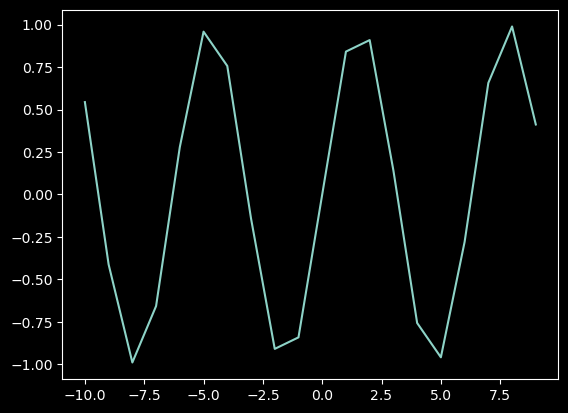

In [107]:
plt.plot(X, y);

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80718)

In [109]:
2**9

512

In [42]:
2**(9-1)

256

In [43]:
combinations = [[10, 5], [20, 10], [30, 15], [50, 10], [100, 50], [200, 100], [500, 250], [600, 300], [800, 400], [1000, 500],
               [1200, 600], [1500, 750], [2000, 1000], [2200, 1100]]

In [44]:
len(combinations)

14

In [45]:
preds = np.zeros((14,20,1))

for idx, (a,b) in enumerate(combinations):
    nn = NeuralNetwork(
    layers=[Dense(neurons=a,
                   activation=Sigmoid()),
            Dense(neurons=b,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
    )

    trainer = Trainer(nn, SGD(lr=0.001))

    trainer.fit(X_train, y_train, X_test, y_test,
           epochs = 100,
           eval_every = 50,
           seed=20190501);
    # eval_regression_model(nn, X_test, y_test)
    
    model_preds = nn.forward(X)
    
    preds[idx] = model_preds
    
    print(f"{idx} completed")
    

Validation loss after 50 epochs is 0.768
Validation loss after 100 epochs is 0.715
0 completed
Validation loss after 50 epochs is 0.874
Validation loss after 100 epochs is 0.860
1 completed
Validation loss after 50 epochs is 1.371
Validation loss after 100 epochs is 0.985
2 completed
Validation loss after 50 epochs is 0.458
Loss increased after epoch 100, final loss was 0.458, using the model from epoch 50
3 completed
Validation loss after 50 epochs is 1.222
Validation loss after 100 epochs is 1.130
4 completed
Validation loss after 50 epochs is 1.452
Validation loss after 100 epochs is 1.026
5 completed
Validation loss after 50 epochs is 2.901
Validation loss after 100 epochs is 2.382
6 completed
Validation loss after 50 epochs is 3.205
Loss increased after epoch 100, final loss was 3.205, using the model from epoch 50
7 completed
Validation loss after 50 epochs is 2.818
Validation loss after 100 epochs is 2.129
8 completed
Validation loss after 50 epochs is 1.666
Validation loss afte

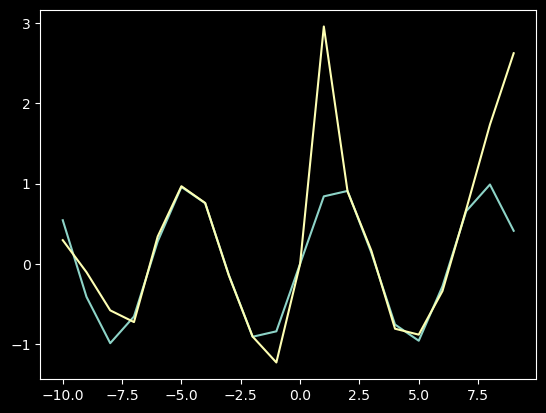

In [46]:
plt.plot(X, y)
plt.plot(X, preds[12,:,:]);

In [47]:
from IPython.display import HTML
from matplotlib import animation

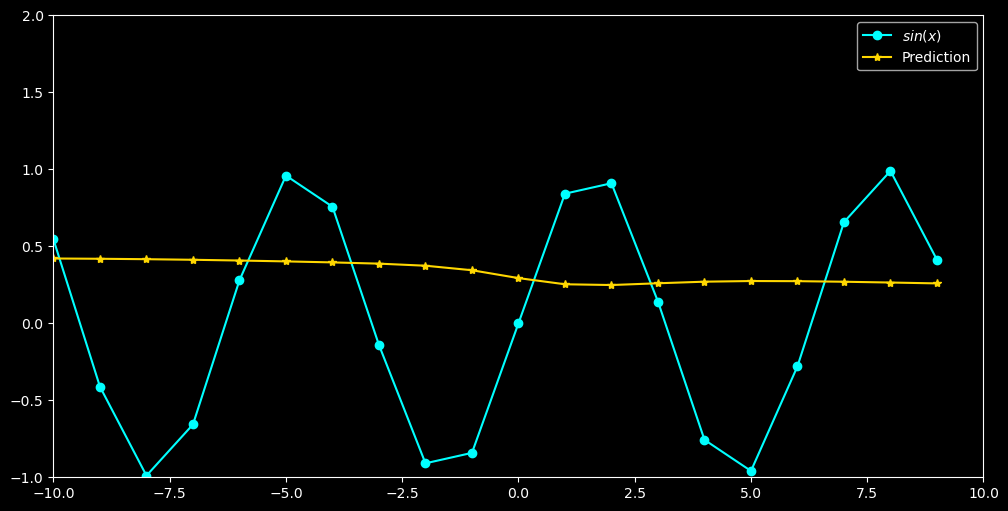

In [61]:
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(X, y, "o-", color="aqua", label=f"$sin(x)$", )
prediction = ax.plot(X, preds[0,:,:], "*-", color="gold", label="Prediction")[0]

ax.set_xlim(-10,10)
ax.set_ylim(-1,2)
plt.legend();
plt.show()

#prepare animation

title = ax.set_title('', fontweight="bold")
# local_min_scat = ax.scatter(initial_local_min, func(initial_local_min), color="orange")

#         grad_annotation = ax.annotate(
#             'Gradient={0:2f}'.format(deriv_func(initial_local_min[0])),
#             xy=(initial_local_min,func(initial_local_min)), xytext=(initial_local_min,func(initial_local_min)+1),
#             arrowprops = {'arrowstyle': "-", 'facecolor' : 'orange'},
#             textcoords='data', color='orange' , rotation=20, fontweight="bold"
#         )

def drawframe(epoch):
    title.set_text('Number of neurons={0:4d}'.format(sum(combinations[epoch])))
    # local_min_scat.set_offsets((x1, y1))
    prediction.set_xdata(X)
    prediction.set_ydata(preds[epoch,:,:])
    # grad_annotation.set_position((x1, y1+1))
    # grad_annotation.xy = (x1, y1)
    # grad_annotation.set_text('Gradient={0:2f}'.format(model_params[epoch, 1]))
    return prediction,

# blit=True re-draws only the parts that have changed.

anim = animation.FuncAnimation(fig, drawframe, frames=14, repeat=False, interval=1000, blit=True) 


writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
# ani.save('gradient1D.gif', writer=writer)
# from IPython.display import HTML
# HTML(anim.to_html5_video())

In [62]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [354]:
X = np.linspace(-10,10).reshape(-1,1)
y = np.sin(X).reshape(-1,1)

In [355]:
nn = NeuralNetwork(
    layers=[Dense(neurons=100,
                   activation=Sigmoid()),
            Dense(neurons=25,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

In [356]:
trainer = Trainer(nn, SGD(lr=0.01))

a = trainer.fit(X, y, X_train, y_train,
       epochs = 100,
       eval_every = 2000,
       seed=20190501);
print()
eval_regression_model(nn, X_train, y_train)


Mean absolute error: 0.51

Root mean squared error 0.59


In [357]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [358]:
a[90,:,:].shape

(50, 1)

In [359]:
X.shape

(50, 1)

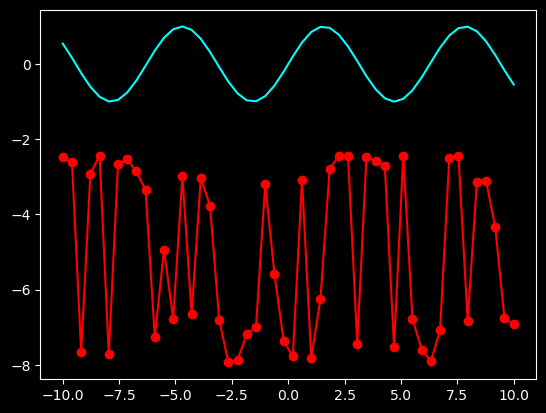

In [360]:
plt.plot(X, y, color="aqua")
plt.plot(X, a[0,:,:], "o-", color="red");

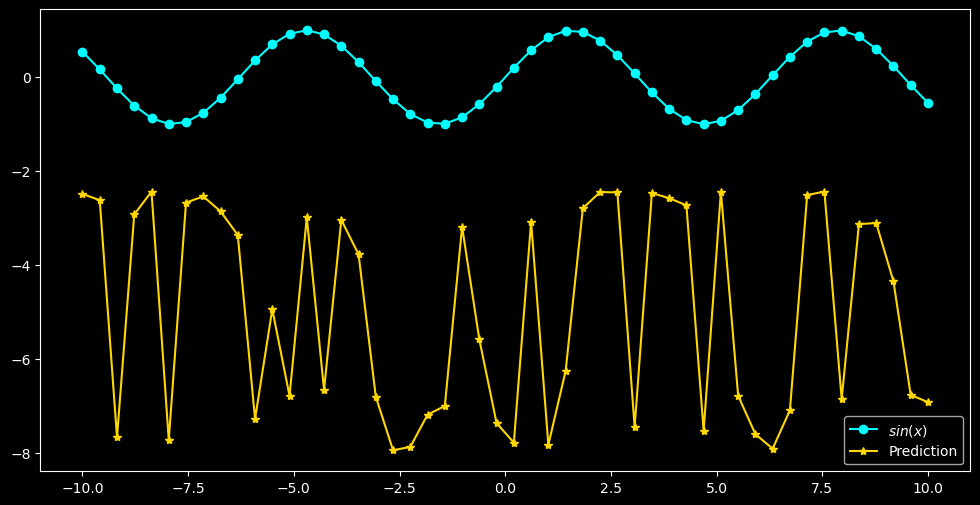

In [362]:
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(X, y, "o-", color="aqua", label=f"$sin(x)$", )
prediction = ax.plot(X, a[0,:,:], "*-", color="gold", label="Prediction")[0]

# ax.set_xlim(-10,10)
# ax.set_ylim(-1,2)
plt.legend();
plt.show()

#prepare animation

title = ax.set_title('', fontweight="bold")
# local_min_scat = ax.scatter(initial_local_min, func(initial_local_min), color="orange")

#         grad_annotation = ax.annotate(
#             'Gradient={0:2f}'.format(deriv_func(initial_local_min[0])),
#             xy=(initial_local_min,func(initial_local_min)), xytext=(initial_local_min,func(initial_local_min)+1),
#             arrowprops = {'arrowstyle': "-", 'facecolor' : 'orange'},
#             textcoords='data', color='orange' , rotation=20, fontweight="bold"
#         )

def drawframe(epoch):
    title.set_text('Epoch={0:4d}'.format(epoch))
    # local_min_scat.set_offsets((x1, y1))
    prediction.set_xdata(X)
    prediction.set_ydata(a[epoch, :,:])
    # grad_annotation.set_position((x1, y1+1))
    # grad_annotation.xy = (x1, y1)
    # grad_annotation.set_text('Gradient={0:2f}'.format(model_params[epoch, 1]))
    return prediction,

# blit=True re-draws only the parts that have changed.

anim = animation.FuncAnimation(fig, drawframe, frames=100, repeat=False, interval=200, blit=True) 


writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
# ani.save('gradient1D.gif', writer=writer)
# from IPython.display import HTML
# HTML(anim.to_html5_video())

In [363]:
from IPython.display import HTML
HTML(anim.to_html5_video())